In [9]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ridge import RidgeRegression

In [10]:

#1- Data loading
ds = pd.read_csv('olympics_100m.csv', sep=',')

#Splitting traing/test
training = ds[0:len(ds)-2]
testing=ds[-2:]

X = training.loc[:,'Year'].values
y = training.loc[:, 'Time'].values
X = X.reshape(len(training),1)


#Split in training + validation and test  
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)
   
#check the result obtained
print(X_train_val.shape)
print(X_test.shape)

(21, 1)
(6, 1)


In [19]:
k=5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

lambda_values = np.array([((10 ** i)) for i in range(-10,4)])

mse_values = []
mse_avg = []

for l in lambda_values:

    for i, (train_index, test_index) in enumerate(kf.split(X)):

        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model = RidgeRegression(l)
        model.train(X_train,y_train)
        y_hat = model.predict(X_val)
        mse = model.MSE(y_hat,y_val)
        mse_values.append(mse)
        print(f'Fold {i} - Lambda {l} - MSE {mse}')
        
    mse_avg.append(np.mean(mse_values))
    mse_values = []
        

print(f'MSE values: {mse_avg}')
min_mse = np.argmin(mse_avg)
print(f'Min MSE: {min_mse}')
lambda_best = lambda_values[min_mse]
print(f'Best lambda: {lambda_best}')



Fold 0 - Lambda 1e-10 - MSE 0.1858345683654421
Fold 1 - Lambda 1e-10 - MSE 0.013831982319136566
Fold 2 - Lambda 1e-10 - MSE 0.020324962949160787
Fold 3 - Lambda 1e-10 - MSE 0.023098643393887362
Fold 4 - Lambda 1e-10 - MSE 0.024845472813200965
Fold 0 - Lambda 1e-09 - MSE 0.1858345683654421
Fold 1 - Lambda 1e-09 - MSE 0.013831982319136566
Fold 2 - Lambda 1e-09 - MSE 0.020324962949160787
Fold 3 - Lambda 1e-09 - MSE 0.023098643393887362
Fold 4 - Lambda 1e-09 - MSE 0.024845472813200965
Fold 0 - Lambda 1e-08 - MSE 0.1858345683663711
Fold 1 - Lambda 1e-08 - MSE 0.013831982319037041
Fold 2 - Lambda 1e-08 - MSE 0.020324962950539097
Fold 3 - Lambda 1e-08 - MSE 0.023098643394057667
Fold 4 - Lambda 1e-08 - MSE 0.02484547281331478
Fold 0 - Lambda 1e-07 - MSE 0.18583456836676424
Fold 1 - Lambda 1e-07 - MSE 0.01383198231885825
Fold 2 - Lambda 1e-07 - MSE 0.020324962950398602
Fold 3 - Lambda 1e-07 - MSE 0.023098643393306112
Fold 4 - Lambda 1e-07 - MSE 0.02484547281274118
Fold 0 - Lambda 1e-06 - MSE 0.

In [20]:
#Coarse to fine validation
mse_values = []
mse_avg = []
lambda_coarse_to_fine = np.array([((lambda_best/10)*i) for i in range(1,20)])
for l in lambda_coarse_to_fine:

    for i, (train_index, test_index) in enumerate(kf.split(X)):

        X_train, X_val = X[train_index], X[test_index]
        y_train, y_val = y[train_index], y[test_index]

        model = RidgeRegression(l)
        model.train(X_train,y_train)
        y_hat = model.predict(X_val)
        mse = model.MSE(y_hat,y_val)
        mse_values.append(mse)
        print(f'Fold {i} - Lambda {l} - MSE {mse}')
        
    mse_avg.append(np.mean(mse_values))
    mse_values = []

print(f'MSE values: {mse_avg}')
min_mse = np.argmin(mse_avg)
print(f'Min MSE: {min_mse}')
lambda_best = lambda_coarse_to_fine[min_mse]
print(f'Best lambda: {lambda_best}')

Fold 0 - Lambda 100.0 - MSE 0.1864913324997675
Fold 1 - Lambda 100.0 - MSE 0.013503962769495954
Fold 2 - Lambda 100.0 - MSE 0.020061271791503067
Fold 3 - Lambda 100.0 - MSE 0.022379034238603764
Fold 4 - Lambda 100.0 - MSE 0.024786783470614686
Fold 0 - Lambda 200.0 - MSE 0.18714712920125146
Fold 1 - Lambda 200.0 - MSE 0.013185627685878618
Fold 2 - Lambda 200.0 - MSE 0.019808982525093347
Fold 3 - Lambda 200.0 - MSE 0.02168474927390888
Fold 4 - Lambda 200.0 - MSE 0.024730431749750523
Fold 0 - Lambda 300.0 - MSE 0.1878019294728188
Fold 1 - Lambda 300.0 - MSE 0.012876785131264704
Fold 2 - Lambda 300.0 - MSE 0.019567855506919425
Fold 3 - Lambda 300.0 - MSE 0.02101521488674455
Fold 4 - Lambda 300.0 - MSE 0.024676376844202985
Fold 0 - Lambda 400.0 - MSE 0.18845570527346722
Fold 1 - Lambda 400.0 - MSE 0.012577247304410712
Fold 2 - Lambda 400.0 - MSE 0.01933765641757275
Fold 3 - Lambda 400.0 - MSE 0.02036987153820682
Fold 4 - Lambda 400.0 - MSE 0.024624578700377552
Fold 0 - Lambda 500.0 - MSE 0.

In [16]:
#Our model
model = RidgeRegression(lambda_best)
model.train(X_train_val,y_train_val)
print(model.weights)
y_hat = model.predict(X_test)
model.MSE(y_hat,y_test)

print(f'MSE: {model.MSE(y_hat,y_test)}')

[ 3.56587058e+01 -1.29471321e-02]
MSE: 0.029372717909755406


In [17]:
#Scikit model
RidgeModel = Ridge(alpha=lambda_best, fit_intercept=True)
RidgeModel.fit(X_train_val,y_train_val)
print(f'Intercept:' + str(RidgeModel.intercept_))
print(f' Weights:' + str(RidgeModel.coef_))
y_hat_sk = RidgeModel.predict(X_test)

print(f'MSE (scikit): {mean_squared_error(y_test,y_hat_sk)}')

Intercept:35.658705799044796
 Weights:[-0.01294713]
MSE (scikit): 0.029372717909743603


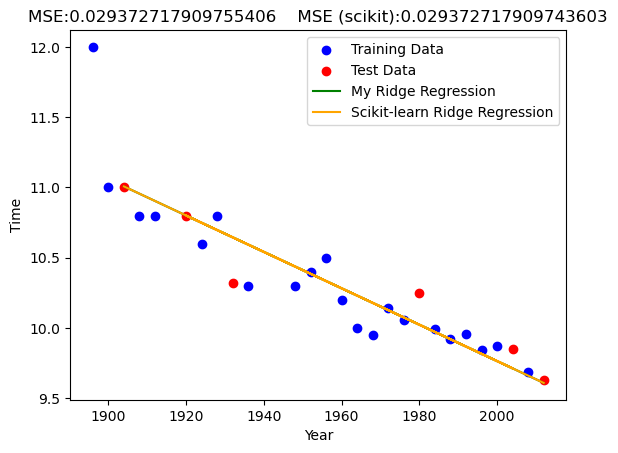

In [18]:
X_train_val = PolynomialFeatures(1).fit_transform(X_train_val)
X_test = PolynomialFeatures(1).fit_transform(X_test)    
# Plotting training data
plt.scatter(X_train_val[:, 1], y_train_val, color='blue', label='Training Data')
# Plotting test data
plt.scatter(X_test[:, 1], y_test, color='red', label='Test Data')

plt.plot(X_test[:, 1], y_hat, label='My Ridge Regression', color='green')
plt.plot(X_test[:,1], y_hat_sk, label='Scikit-learn Ridge Regression', color='orange')

plt.title('MSE:' + str(model.MSE(y_hat,y_test)) + '    MSE (scikit):' + str(mean_squared_error(y_test,y_hat_sk)))
plt.xlabel('Year')
plt.ylabel('Time')
plt.legend()
plt.show()